In [2]:
import os
import random
import warnings
from datetime import datetime
from functools import partial
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from fastai.callback.progress import CSVLogger
from fastai.callback.tracker import EarlyStoppingCallback, SaveModelCallback
from fastai.learner import DataLoaders
from fastai.metrics import RocAuc
from fastai.optimizer import OptimWrapper
from fastai.vision.all import Learner
from sklearn.model_selection import train_test_split
from torch import nn
from torch.utils.data import DataLoader, Dataset
from transformers import (BertModel, BertTokenizer, DistilBertModel,
                          DistilBertTokenizerFast, RobertaModel,
                          RobertaTokenizer)

In [3]:
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

In [4]:
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

torch.cuda.manual_seed_all(42)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [5]:
data_translated = pd.read_csv("df_translated.csv")

In [6]:
TEST_SIZE = 0.25
labels = ['Anger', 'Fear', 'Joy', 'Sadness', 'Surprise']

In [7]:
with_attention = True
# with_attention = False

with_pos_weights = True
# with_pos_weights = False

# pretrained_model = "distilbert"
pretrained_model = "bert"
# pretrained_model = "roberta"

finetune_bert = False

N_EPOCHS = 5 if finetune_bert else 20

model_config = {
    "distilbert": {
        "tokenizer": DistilBertTokenizerFast,
        "model": DistilBertModel,
        "model_name": "distilbert-base-uncased"
    },
    "bert": {
        "tokenizer": BertTokenizer,
        "model": BertModel,
        "model_name": "bert-base-uncased"
    },
    "roberta": {
        "tokenizer": RobertaTokenizer,
        "model": RobertaModel,
        "model_name": "FacebookAI/roberta-base"
    }
}

config = model_config.get(pretrained_model)

if config:
    tokenizer = config["tokenizer"]
    model_to_use = config["model"]
    model_name = config["model_name"]
else:
    raise ValueError(f"Model {pretrained_model} not supported!")

print(f"Using {model_name} with tokenizer {tokenizer}")

Using bert-base-uncased with tokenizer <class 'transformers.models.bert.tokenization_bert.BertTokenizer'>


In [8]:
which_data = "original_eng" # only origina dataset
# which_data = "original_backtranslated_eng" # original plus backtranslated
# which_data = "translated" # original and translated from different languages
# which_data = "translated_backtranslated" # original, backtranslated and translated from different languages

if which_data == "original_eng":
    df = data_translated[data_translated["comment"] == "original_eng"]
if which_data == "original_backtranslated_eng":
    df = data_translated[(data_translated["comment"] == "original_eng") | (data_translated["comment"] == "backtranslate_de")]
if which_data == "translated":
    df = data_translated[(data_translated["comment"] != "backtranslate_de") & data_translated.notna()]
if which_data == "translated_backtranslated":
    df = data_translated[data_translated.notna()]

In [9]:
df["comment"].unique()

array(['original_eng'], dtype=object)

<Figure size 800x600 with 0 Axes>

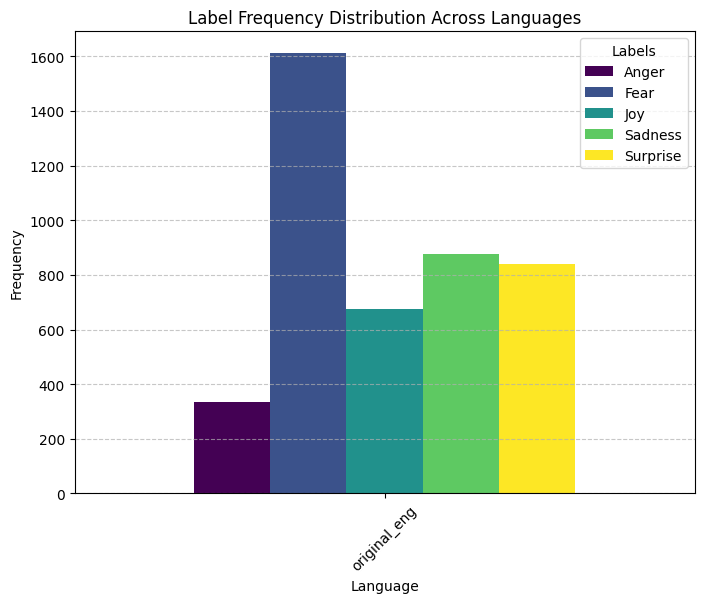

In [10]:
language_label_distribution = df.groupby(['comment'])[labels].sum()


plt.figure(figsize=(8, 6))
ax = language_label_distribution.plot(kind='bar', figsize=(8, 6), width=0.8, colormap="viridis")

plt.title("Label Frequency Distribution Across Languages")
plt.xlabel("Language")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.legend(title="Labels")
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.show()

In [11]:
MAX_LEN = df.text.str.len().max()
print(f"Max length of text: {MAX_LEN}")

Max length of text: 450


In [12]:
# Dataset definition
class EmotionDataset(Dataset):
    def __init__(self, data, tokenizer, max_len=128):
        self.texts = data["text"].tolist()
        self.labels = data[["Anger", "Fear", "Joy", "Sadness", "Surprise"]].values
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        labels = torch.tensor(self.labels[idx], dtype=torch.float)
        encodings = self.tokenizer(
            text,
            max_length=self.max_len,
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        )
        input_ids = encodings["input_ids"].squeeze(0)
        attention_mask = encodings["attention_mask"].squeeze(0)
        return (input_ids, attention_mask), labels

In [13]:
class ModelMultiLabel(torch.nn.Module):
    def __init__(self, model, model_name, num_labels):
        super(ModelMultiLabel, self).__init__()
        self.bert = model.from_pretrained(model_name, num_labels=num_labels)
        self.dropout = nn.Dropout(0.1)
        self.fc = nn.Linear(self.bert.config.hidden_size, num_labels)
        self.layer_norm = nn.LayerNorm(self.bert.config.hidden_size)

        if not finetune_bert:
            for param in self.bert.parameters():
                param.requires_grad = False

    def forward(self, x):
        input_ids, attention_mask = x
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        outputs = self.layer_norm(outputs.last_hidden_state[:, 0])
        pooled_output = self.dropout(outputs)
        return self.fc(pooled_output)
    

In [14]:
# class WeightedPooling(nn.Module):
#     def __init__(self, hidden_size):
#         super(WeightedPooling, self).__init__()
#         self.pooling = nn.Sequential(
#             nn.Linear(hidden_size, 128),
#             nn.Tanh(),
#             nn.Linear(128, 1),
#             nn.Sigmoid()  # Apply softmax across the sequence length
#         )

#     def forward(self, hidden_states, attention_mask):
#         weights = self.pooling(hidden_states)
#         weights = weights * attention_mask.unsqueeze(-1)  # Apply mask

#         weights = weights / (weights.sum(dim=1, keepdim=True) + 1e-9)

#         pooled_output = torch.sum(weights * hidden_states, dim=1)
#         return pooled_output, weights


class MultiHeadAttentionPooling(nn.Module):
    def __init__(self, hidden_size, num_heads=8):
        super(MultiHeadAttentionPooling, self).__init__()
        self.multihead_attn = nn.MultiheadAttention(embed_dim=hidden_size, num_heads=num_heads, batch_first=True)
        self.attention_fc = nn.Sequential(
            nn.Linear(hidden_size, 128),
            nn.Tanh(),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, hidden_states, attention_mask):
        attn_output, _ = self.multihead_attn(hidden_states, hidden_states, hidden_states, key_padding_mask=~attention_mask.bool())
        weights = self.attention_fc(attn_output)
        weights = weights * attention_mask.unsqueeze(-1)
        weights = weights / (weights.sum(dim=1, keepdim=True) + 1e-9)
        pooled_output = torch.sum(weights * attn_output, dim=1)
        return pooled_output, weights



# model + Multi-Head Attention Pooling for Multi-label Emotion Classification
class ModelAttentionMultiLabel(torch.nn.Module):
    def __init__(self, model, model_name,  num_labels):
        super(ModelAttentionMultiLabel, self).__init__()
        self.bert = model.from_pretrained(model_name, num_labels=num_labels)
        self.dropout = nn.Dropout(0.1)
        hidden_size = self.bert.config.hidden_size
        self.layer_norm = nn.LayerNorm(self.bert.config.hidden_size)

        self.attention_pooling = MultiHeadAttentionPooling(hidden_size)

        self.classifier = nn.Sequential(
            nn.Dropout(0.1),
            nn.Linear(hidden_size, 256),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(256, num_labels),
        )

        for param in self.bert.parameters():
            param.requires_grad = False

    def forward(self, x):
        input_ids, attention_mask = x
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        hidden_states = outputs.last_hidden_state  # Shape: (batch_size, seq_len, hidden_size)
        hidden_states = self.layer_norm(hidden_states)

        pooled_output, attention_weights = self.attention_pooling(hidden_states, attention_mask)

        logits = self.classifier(pooled_output)

        return logits

In [15]:
train_data, valid_data = train_test_split(df, test_size=TEST_SIZE, random_state=42)
tokenizer = tokenizer.from_pretrained(model_name)

In [16]:
train_dataset = EmotionDataset(
    train_data,
    tokenizer
)
valid_dataset = EmotionDataset(
    valid_data,
    tokenizer
)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=16)

In [17]:
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print(f"Using device: {device}") 

if with_attention:
    model = ModelAttentionMultiLabel(model_to_use, model_name, len(labels)).to(device)
else:
    model = ModelMultiLabel(model_to_use, model_name,len(labels)).to(device)


if with_pos_weights:
    values = train_data[labels].values.tolist()
    labels_tensor = torch.tensor(values, dtype=torch.float)
    num_positives = labels_tensor.sum(dim=0)
    num_negatives = labels_tensor.shape[0] - num_positives
    pos_weight = num_negatives / num_positives
    pos_weight_tensor = torch.tensor(pos_weight, dtype=torch.float).to(device)

    loss_func = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weight_tensor)
else:
    loss_func = torch.nn.BCEWithLogitsLoss()

Using device: cuda


In [18]:
timestamp = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
name = f"{pretrained_model}_attention_{with_attention}_pos_weights_{with_pos_weights}_{which_data}"
output_path = Path(f'model_{name}_{timestamp}')
output_path.mkdir(exist_ok=True, parents=True)

dls = DataLoaders(train_loader, valid_loader, device=device)

learn = Learner(
    dls,
    model,
    loss_func=loss_func,
    opt_func=partial(OptimWrapper, opt=torch.optim.AdamW),
    metrics=[RocAuc()],
    path=output_path
)

cbs = [
    SaveModelCallback(monitor='valid_loss', fname='best_valid'),
    EarlyStoppingCallback(monitor='valid_loss', patience=9),
    CSVLogger()
]

In [19]:
learn.fit_one_cycle(n_epoch=N_EPOCHS, reset_opt=True, lr_max=1e-4, wd=1e-2, cbs=cbs)

epoch,train_loss,valid_loss,roc_auc_score,time


Better model found at epoch 0 with valid_loss value: 0.9237064123153687.
Better model found at epoch 1 with valid_loss value: 0.8610752820968628.
Better model found at epoch 2 with valid_loss value: 0.6362388134002686.
Better model found at epoch 3 with valid_loss value: 0.5877664685249329.
No improvement since epoch 3: early stopping


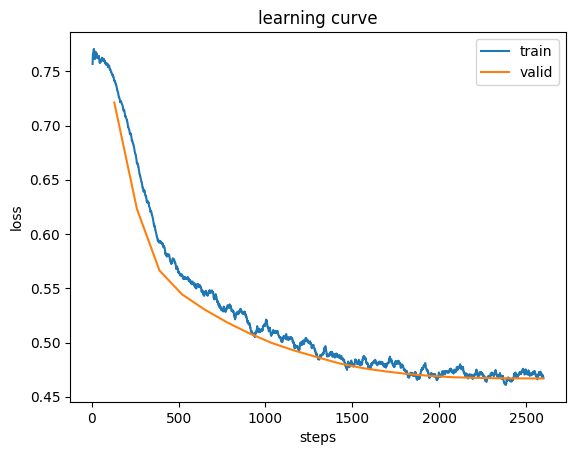

In [46]:
learn.recorder.plot_loss()
plt.show()

In [20]:
learn.save(f'model_last')


Path('model_bert_attention_True_pos_weights_True_original_eng_2025-02-10_10-49-52/models/model_last.pth')

In [21]:
df_eval = pd.read_csv('public_data_test/track_a/dev/eng.csv')
# df_eval = valid_data
# dev_df = valid_data
df_eval.head()


,id,text,anger,fear,joy,sadness,surprise
0,eng_dev_track_a_00001,Older sister (23 at the time) is a Scumbag Stacy.,1,0,0,0,0
1,eng_dev_track_a_00002,"And I laughed like this: garhahagar, because my mouth was full of cotton and shit to bite down on and sharp objects and drills.",0,1,0,0,0
2,eng_dev_track_a_00003,It overflowed and brown shitty diarrhea water came flooding under the stall wall into my wife's stall.,1,1,0,1,1
3,eng_dev_track_a_00004,Its very dark and foggy.,0,1,0,0,0
4,eng_dev_track_a_00005,"Then she tried to, like, have sex with/strangle everyone.",1,1,0,0,1


In [22]:
def predict_classes(learner, texts, tokenizer, max_len=128):
    predictions = []

    learner.model.eval()
    with torch.no_grad():
        for text in texts:
            encoded = tokenizer(
                text,
                padding="max_length",
                truncation=True,
                max_length=max_len,
                return_tensors="pt"
            )
            input_ids = encoded["input_ids"].to(device)
            attention_mask = encoded["attention_mask"].to(device)

            logits = learner.model((input_ids, attention_mask))
            probs = torch.sigmoid(logits) 
            predicted_labels = (probs > 0.5).int().tolist()[0]  
            # predicted_labels = (logits > 0).int().tolist()[0]  

            predictions.append(predicted_labels)
    return predictions


# Load best model
best_model_path = output_path / 'models' / 'best_valid.pth'
learn.load(best_model_path.stem)


df_eval = df_eval.dropna(subset=['text'])
texts = df_eval["text"].tolist()
predictions = predict_classes(learn, texts, tokenizer)

emotion_labels = ["pred_anger", "pred_fear", "pred_joy", "pred_sadness", "pred_surprise"]
prediction_df = pd.DataFrame(predictions, columns=emotion_labels)
df_eval[emotion_labels] = prediction_df.values

df_eval["True Labels"] = df_eval[["anger", "fear", "joy", "sadness", "surprise"]].values.tolist()

df_eval["Predicted Labels"] = df_eval[emotion_labels].values.tolist()

df_eval["True Labels"] = df_eval["True Labels"].apply(lambda x: str(x))
df_eval["Predicted Labels"] = df_eval["Predicted Labels"].apply(lambda x: str(x))

results_path = Path(f"results_{name}_{timestamp}")
results_path.mkdir(exist_ok=True, parents=True)
output_csv = f"{results_path}/dev_predictions.csv"

df_eval.to_csv(output_csv, index=False)

print(f"Predictions saved to {output_csv}")

Predictions saved to results_bert_attention_True_pos_weights_True_original_eng_2025-02-10_10-49-52/dev_predictions.csv


In [24]:
df_eval["True Labels"] = df_eval[["anger", "fear", "joy", "sadness", "surprise"]].values.tolist()

df_eval["Predicted Labels"] = df_eval[emotion_labels].values.tolist()


In [25]:
from sklearn.metrics import f1_score
true_labels = np.array(df_eval["True Labels"].tolist())
pred_labels = np.array(df_eval["Predicted Labels"].tolist())

f1_scores = {
    emotion: f1_score(true_labels[:, i], pred_labels[:, i], average="binary")
    for i, emotion in enumerate(emotion_labels)
}

print("F1 Scores by Emotion:")
for emotion, score in f1_scores.items():
    print(f"{emotion}: {score:.2f}")

average_f1 = np.mean(list(f1_scores.values()))
print(f"\nAverage F1 Score: {average_f1:.2f}")

F1 Scores by Emotion:
pred_anger: 0.80
pred_fear: 0.71
pred_joy: 0.71
pred_sadness: 0.71
pred_surprise: 0.63

Average F1 Score: 0.71
